<div style="text-align: center;">

# From scattered data to gridded products

## [Tutorial at Transform 2020](https://sched.co/c7KE) 💚

<img src="https://github.com/fatiando/verde/raw/c77c7d84aa361fb1209ae38f7d6a05253a4518fc/doc/_static/readme-banner.png" style="width: 70%">

### A hands-on tour of Verde, a Python package for processing and gridding geophysical/geospatial data with a twist of machine learning.
    
</div>

<br>

**Instructors:**
[Leonardo Uieda](https://www.leouieda.com/)<sup>1</sup> and
[Santiago Soler](https://santisoler.github.io/)<sup>2,3</sup>

<sup>1</sup>University of Liverpool, UK |
<sup>2</sup>CONICET, Argentina | 
<sup>3</sup>Universidad Nacional de San Juan, Argentina

## Useful links

* Live stream: https://youtu.be/-xZdNdvzm3E
* Workshop material: https://github.com/fatiando/transform2020 
* Verde documentation | https://www.fatiando.org/verde

## Contents

1. [Loading data](#load)
1. [Projections](#projections)
1. [Trends](#trends)
1. [Blocked reductions](#reduction)
1. [Gridding with splines](#gridding)
1. [Chainning operations](#chain)
1. [Training and validation split](#train-test-split)
1. [Cross-validation](#cv)
1. [Hyper-parameter optimization](#splinecv)

## Importing libraries

The first thing we'll do is import all of the libraries that we need:

In [3]:
import verde as vd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyproj
import pooch

<a id="load"></a>

## Loading data

In [156]:
fname = pooch.retrieve(
    "https://raw.githubusercontent.com/fatiando/transform2020/master/data/cd8794.m77t", 
    known_hash="bd4373af29e49c25518544953dbc27aa1907ae2c3bf5d0c8e03ae4fc3ed7e984",
)

In [157]:
data = pd.read_csv(fname, sep="\t")
data

,SURVEY_ID,TIMEZONE,DATE,TIME,LAT,LON,POS_TYPE,NAV_QUALCO,BAT_TTIME,CORR_DEPTH,...,MAG_RESSEN,MAG_DICORR,MAG_SDEPTH,MAG_QUALCO,GRA_OBS,EOTVOS,FREEAIR,GRA_QUALCO,LINEID,POINTID
0,CD8794,0,NaN,NaN,54.78548,-20.05763,1,NaN,NaN,1625.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CD8794,0,NaN,NaN,54.78548,-20.06063,1,NaN,NaN,1624.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CD8794,0,NaN,NaN,54.78543,-20.06453,1,NaN,NaN,1623.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CD8794,0,NaN,NaN,54.78538,-20.06749,1,NaN,NaN,1620.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CD8794,0,NaN,NaN,54.78537,-20.07117,1,NaN,NaN,1616.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68158,CD8794,0,NaN,NaN,54.30820,-18.52462,1,NaN,NaN,1775.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68159,CD8794,0,NaN,NaN,54.30908,-18.52784,1,NaN,NaN,1775.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68160,CD8794,0,NaN,NaN,54.30983,-18.53072,1,NaN,NaN,1780.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68161,CD8794,0,NaN,NaN,54.31061,-18.53368,1,NaN,NaN,1789.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


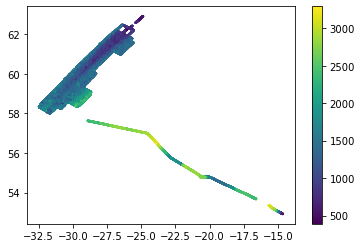

In [158]:
plt.figure()
plt.scatter(data.LON, data.LAT, c=data.CORR_DEPTH, s=2)
plt.colorbar()

In [160]:
data = data[vd.inside((data.LON, data.LAT), [-33, -24, 57.5, 63])]
data = data.dropna(axis=0, subset=["CORR_DEPTH"])
data

,SURVEY_ID,TIMEZONE,DATE,TIME,LAT,LON,POS_TYPE,NAV_QUALCO,BAT_TTIME,CORR_DEPTH,...,MAG_RESSEN,MAG_DICORR,MAG_SDEPTH,MAG_QUALCO,GRA_OBS,EOTVOS,FREEAIR,GRA_QUALCO,LINEID,POINTID
2844,CD8794,0,NaN,NaN,57.50021,-27.98834,1,NaN,NaN,2547.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2845,CD8794,0,NaN,NaN,57.50079,-27.99207,1,NaN,NaN,2546.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2846,CD8794,0,NaN,NaN,57.50129,-27.99563,1,NaN,NaN,2543.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2847,CD8794,0,NaN,NaN,57.50192,-28.00071,1,NaN,NaN,2542.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2848,CD8794,0,NaN,NaN,57.50237,-28.00499,1,NaN,NaN,2534.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66537,CD8794,0,NaN,NaN,61.41586,-27.76476,1,NaN,NaN,1012.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66538,CD8794,0,NaN,NaN,61.41481,-27.76182,1,NaN,NaN,1008.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66539,CD8794,0,NaN,NaN,61.41371,-27.75885,1,NaN,NaN,1017.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66540,CD8794,0,NaN,NaN,61.41263,-27.75599,1,NaN,NaN,1045.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


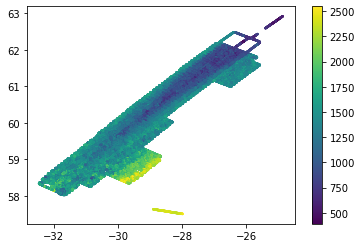

In [161]:
plt.figure()
plt.scatter(data.LON, data.LAT, c=data.CORR_DEPTH, s=2)
plt.colorbar()

<a id="projections"></a>

## Projections

In [128]:
projection = pyproj.Proj(proj="merc", lat_ts=data.LAT.mean())

In [129]:
coordinates = projection(data.LON.values, data.LAT.values)

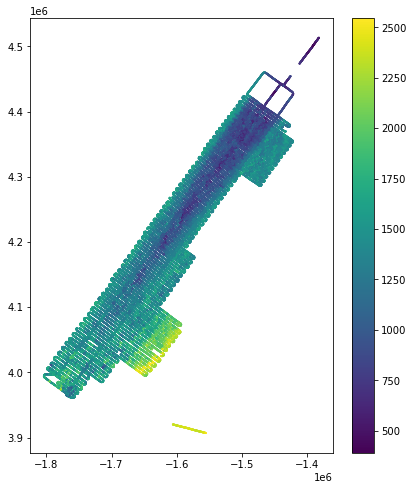

In [149]:
plt.figure(figsize=(7, 8))
plt.scatter(coordinates[0], coordinates[1], c=data.CORR_DEPTH, s=1)
plt.axis("scaled")
plt.colorbar()

<a id="trends"></a>

## Trends

In [141]:
trend = vd.Trend(degree=1)
trend.fit(coordinates, data.CORR_DEPTH)

Trend(degree=1)

In [142]:
trend.coef_

array([ 2.17749145e+04,  3.10790104e-03, -3.68459046e-03])

In [143]:
trend_values = trend.predict(coordinates)

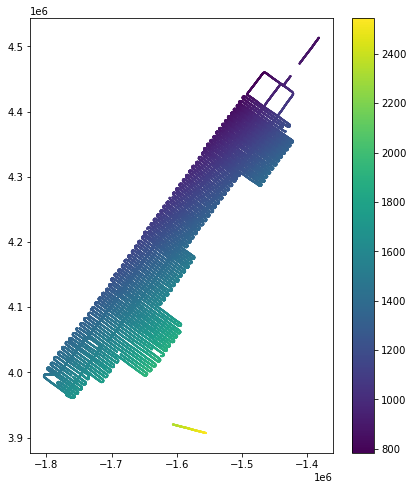

In [174]:
plt.figure(figsize=(7, 8))
plt.scatter(coordinates[0], coordinates[1], c=trend_values, s=1)
plt.axis("scaled")
plt.colorbar()

In [151]:
residuals = data.CORR_DEPTH - trend_values

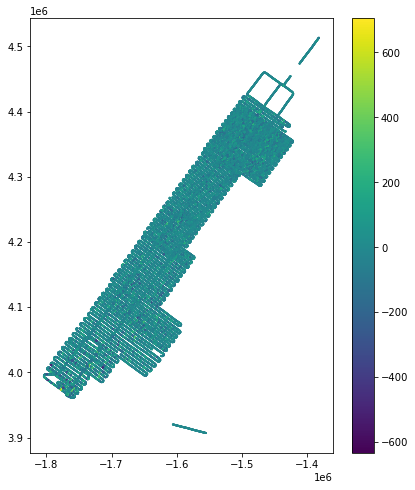

In [173]:
plt.figure(figsize=(7, 8))
plt.scatter(coordinates[0], coordinates[1], c=residuals, s=1)
plt.axis("scaled")
plt.colorbar()

<a id="reduction"></a>

## Blocked reductions

In [162]:
reducer = vd.BlockReduce(np.median, spacing=5e3)
block_coords, block_bathymetry = reducer.filter(coordinates, data.CORR_DEPTH)

In [164]:
data.shape

(63693, 26)

In [165]:
block_bathymetry.shape

(2094,)

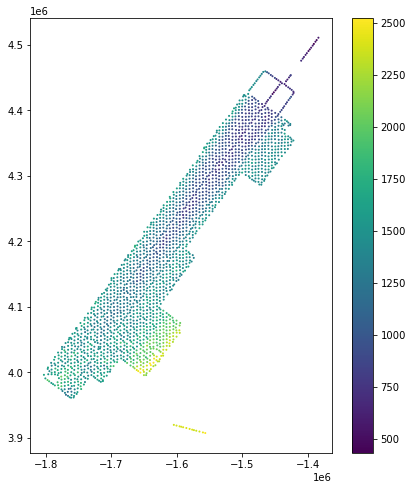

In [163]:
plt.figure(figsize=(7, 8))
plt.scatter(block_coords[0], block_coords[1], c=block_bathymetry, s=1)
plt.axis("scaled")
plt.colorbar()

<a id="gridding"></a>

## Gridding with splines

In [166]:
spline = vd.Spline()
spline.fit(block_coords, block_bathymetry)

Spline()

In [167]:
predicted = spline.predict(coordinates)
residuals = data.CORR_DEPTH - predicted

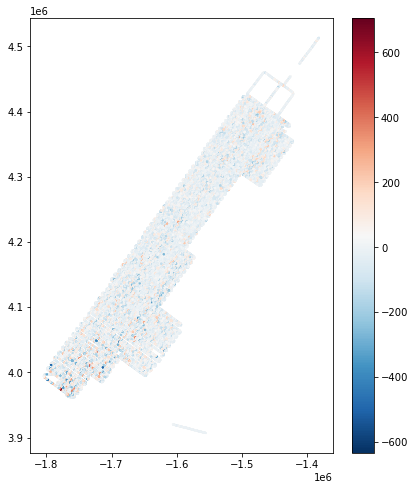

In [169]:
plt.figure(figsize=(7, 8))
plt.scatter(coordinates[0], coordinates[1], c=residuals, s=1, cmap="RdBu_r")
plt.axis("scaled")
plt.colorbar()

In [175]:
grid_coords = vd.grid_coordinates([-1.8e6, -1.4e6, 3.9e6, 4.5e6], spacing=5e3)

In [176]:
grid_bathymetry = spline.predict(grid_coords)

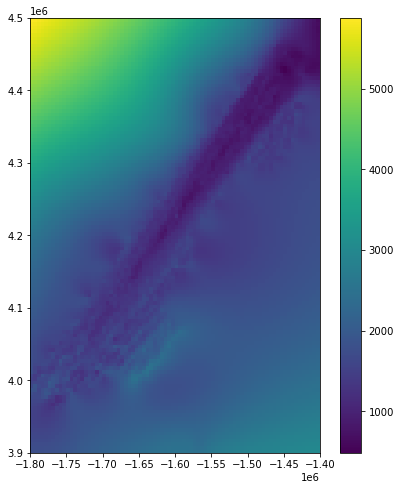

In [177]:
plt.figure(figsize=(7, 8))
plt.pcolormesh(grid_coords[0], grid_coords[1], grid_bathymetry)
plt.axis("scaled")
plt.colorbar()

<div style="background-color: #a3ff8e; border-radius: 3px; padding: 10px; text-align: center;">

# ☕ Break (20 min)
    
</div>

<a id="chain"></a>

## Chainning operations

<a id="train-test-split"></a>

## Training and validation split

<a id="cv"></a>

## Cross-validation

<a id="splinecv"></a>

## Hyper-parameter optimization

<div style="background-color: #a3ff8e; border-radius: 3px; padding: 10px; text-align: center;">

# ☕ Break (20 min)
    
</div>

## License

All code and text in this notebook is free software: you can redistribute it and/or
modify it under the terms of the BSD 3-clause License.
A copy of this license is provided in [LICENSE](https://github.com/fatiando/transform2020/blob/master/LICENSE).